In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
31415,We have five cats - one an elderly cat of 15 y...,Kitty Carbo loaded Junk Food
59260,London Cuppa Tea 440 bags is a good everyday b...,Cuppa review
60473,my fiance and i really like engry shot!! it s...,great enegry!
334,Taste like it is stale. Will not order this a...,Does not taste very good
7309,Your guess is as good as mine regarding what F...,"Festival doesn't tell us what they mean by ""Fr..."
86486,This stuff is great -- tastes kind of like tac...,YUM
61506,"As a standard mayo- this tastes a little odd, ...",Great for sushi making
73315,I was tired of the standard bag of chips and c...,My personal favorite
1521,I am enjoying this coffee but the vanilla is a...,"Nice strength, maybe too much vanilla?"
68893,I use currants a lot. They are difficult to fi...,Currants are a delicious addition


In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [14]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


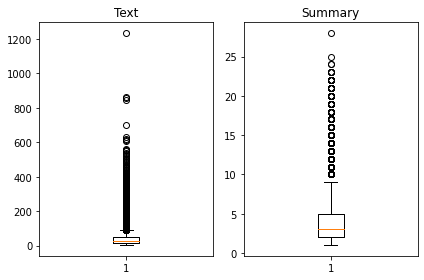

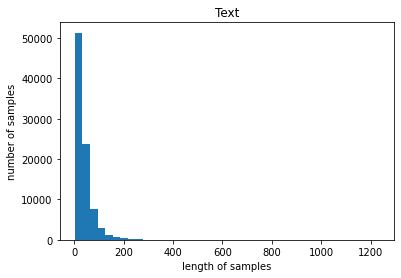

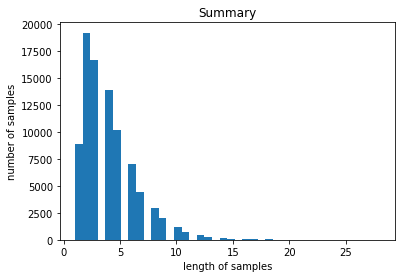

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
text_max_len = 50
summary_max_len = 8

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[  220 36624 64018 ... 54000 14577 64229]


In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31963
등장 빈도가 6번 이하인 희귀 단어의 수: 23716
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8247
단어 집합에서 희귀 단어의 비율: 74.19829177486469
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.392680763650513


In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[15, 9, 74, 853, 2, 122, 15, 39, 450, 119, 623, 108], [32, 44, 5257, 13, 7, 78, 208, 159, 1200, 77, 250, 100, 4280], [3, 2193, 90, 185, 3, 9, 10, 53, 117, 76, 1004, 430, 1205, 1324, 785, 199, 371]]


In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10478
등장 빈도가 5번 이하인 희귀 단어의 수: 8103
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2375
단어 집합에서 희귀 단어의 비율: 77.33346058408092
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.867252444329586


In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 73], [1], [1, 1668, 10, 29, 225], [1, 24, 16], [1, 3, 52, 16]]
target
decoder  [[73, 2], [2], [1668, 10, 29, 225, 2], [24, 16, 2], [3, 52, 16, 2]]


In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1264
삭제할 테스트 데이터의 개수 : 334
훈련 데이터의 개수 : 51391
훈련 레이블의 개수 : 51391
테스트 데이터의 개수 : 12829
테스트 레이블의 개수 : 12829


In [37]:
# 패딩 추가 (전처리 완료)
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 142s 662ms/step - loss: 2.6966 - val_loss: 2.4139
Epoch 2/50
201/201 [==============================] - 133s 662ms/step - loss: 2.3578 - val_loss: 2.2810
Epoch 3/50
201/201 [==============================] - 134s 667ms/step - loss: 2.2267 - val_loss: 2.1679
Epoch 4/50
201/201 [==============================] - 133s 664ms/step - loss: 2.1116 - val_loss: 2.0774
Epoch 5/50
201/201 [==============================] - 135s 671ms/step - loss: 2.0279 - val_loss: 2.0207
Epoch 6/50
201/201 [==============================] - 131s 653ms/step - loss: 1.9640 - val_loss: 1.9863
Epoch 7/50
201/201 [==============================] - 130s 649ms/step - loss: 1.9097 - val_loss: 1.9531
Epoch 8/50
201/201 [==============================] - 129s 643ms/step - loss: 1.8643 - val_loss: 1.9256
Epoch 9/50
201/201 [==============================] - 129s 640ms/step - loss: 1.8234 - val_loss: 1.9069
Epoch 10/50
201/201 [==============================] - 128s 638m

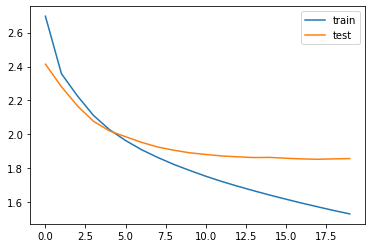

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : tried brands dried mango brand always one prefer local refer dried mango seasonal fruit available much time amazon always find favorite brand find price mangos arrive timely manner good shelf life 
실제 요약 : delicious dried 
예측 요약 :  love these


원문 : pretty good opinion nearly good teriyaki beef steak nuggets bad either sort prime rip au jus flavoring tell meat prime rib definitely work try see like 
실제 요약 : pretty good 
예측 요약 :  not bad


원문 : great coffee regular cup tried smallest cup espresso delicious give try 
실제 요약 : tully italian roast 
예측 요약 :  great coffee


원문 : pumps color matches perfectly work great problem go lock pump pump one shot syrup need plan ahead know much trouble used business party would great going go back regular cap spoon 
실제 요약 : and pump works perfectly but 
예측 요약 :  great product


원문 : time favorite tea nice hint cinnamon great time day easily go teabags day probably percent hot tea drink bigelow cinnamon stick tea tried cinnamon teas far best one ye

예측 요약 :  not as good as the


원문 : toy excellent golden retriever teething perfect stars product description accurate picture showed rex received big deal multiple description indicate one getting 
실제 요약 : excellent product but buyer beware 
예측 요약 :  not for


원문 : chocolates absolutely best smooth taste almost delicate texture absolute must chocolate fan never fan milk chocolate chocolates absolute exception highly recommend chocolates anyone loves chocolate much 
실제 요약 : chocolate delightful treat 
예측 요약 :  best chocolate ever


원문 : chips regular house fact chips buy bbq flavor favorite buy single serving packs buy bigger bag hard stop eating 
실제 요약 : best chips ever 
예측 요약 :  great chips


원문 : cherry jolly ranchers definitely best flavor package way get cherry arrived fresh tasty exactly hoped stix different suppliers bit taste sort melted within wrapper 
실제 요약 : only way to get all cherry 
예측 요약 :  love these


원문 : got ekobrew today tried fan since came ekobrew design seems beat

In [50]:
import requests
from summa.summarizer import summarize

In [51]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [52]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [53]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [54]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [55]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## 여기부터 실습

## Step 1. 데이터 수집하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [57]:
data.sample(10)

,headlines,text
49092,Saddam Hussein's daughter on Iraq's most wante...,Former Iraqi dictator Saddam Hussein's eldest ...
81044,Reliance stock hits 9 year high as Jio announc...,Mukesh Ambani-led Reliance Industries stock on...
93253,"People in Mumbai clean 20,000 kg of trash",Nearly 100 residents of Kandivali in Mumbai ca...
20941,UAE deports Indian over suspected links with ISIS,The UAE has deported a 36-year-old engineer fr...
80521,India's Premier Futsal to be bigger this year:...,Former World Cup-winning Brazilian footballer ...
9561,Public sector banks' losses rise 3.5 times hig...,"Due to mounting bad loans, state-owned banks s..."
94954,100 cities organise pillow fights to help home...,Over 100 cities around the world recently host...
14502,Turkey Prez tells ministers to stop using US f...,Turkish President Recep Tayyip ErdoÃÂan on S...
17815,Nadal would be great as Real Madrid President:...,Real Madrid's current President Florentino Per...
37757,Kane scores in injury time to help England sta...,"Captain Harry Kane scored twice, including an ..."


## Step 2. 데이터 전처리하기 (추상적 요약)
### 2-1) 데이터 정리하기

In [58]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [59]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


In [60]:
print(data.isnull().sum()) # 결측값 X

headlines    0
text         0
dtype: int64


In [61]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [62]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [63]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# 요약할 때 뭘 추가 삭제해야할지는 영어 사용자가 아니면 생각하기 어렵기때문에, 일단 패스 마지막까지 결과를 보고 고민해보자
# 대충 자주사용하는 단축어나 구어체, 자주 나오는 오타, 신조어 등등 있을꺼같은데... 영어는 잘 모르겠음.

In [64]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [65]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [66]:
data['text'] = clean_text
data['headlines'] = clean_headlines
data.replace('', np.nan, inplace=True)

In [67]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 2-2) 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


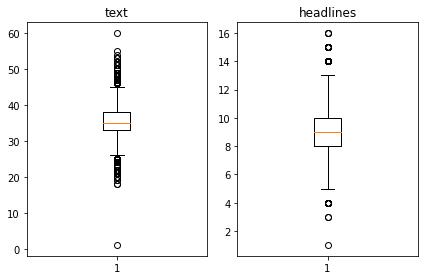

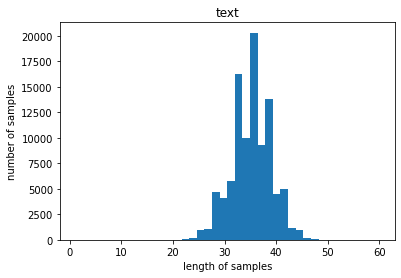

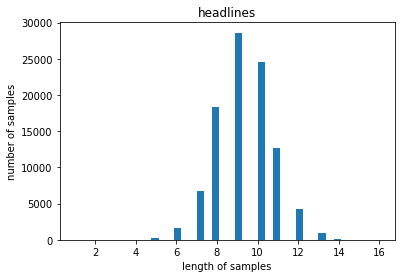

In [68]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 분포를 확인해보니 따로 최대길이를 지정해서 삭제할 필요는 없어보인다.
### 1글자짜리 저 데이터가 좀 거슬리긴하는데 패딩처리하면 큰 문제는 없을 듯

### 2-3) 시작 토큰과 종료 토큰 추가

In [69]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [70]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 2-4) 훈련 데이터와 테스트 데이터의 분리

In [71]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[79619 60634  9383 ... 85031 16087 71359]


In [72]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [73]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19652


In [74]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78610
훈련 레이블의 개수 : 78610
테스트 데이터의 개수 : 19652
테스트 레이블의 개수 : 19652


### 2-5) 정수 인코딩

In [75]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [76]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69520
등장 빈도가 6번 이하인 희귀 단어의 수: 47366
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22154
단어 집합에서 희귀 단어의 비율: 68.13291139240506
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4865288590681858


In [77]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) 

In [78]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[160, 20, 60, 1590, 313, 1962, 6259, 21, 116, 454, 9622, 3916, 1962, 746, 14835, 24, 4725, 20, 4, 2496, 379, 142, 1361, 1, 10704, 407, 10705, 313, 1962], [3, 13, 64, 43, 28, 5, 16, 2550, 14299, 6708, 5499, 7158, 711, 2018, 253, 478, 365, 2463, 347, 636, 5500, 1157, 5, 16, 612, 129, 484, 250, 1304, 1445, 5, 86], [1792, 119, 988, 569, 59, 1, 4094, 279, 101, 310, 12565, 1500, 18351, 569, 1495, 3583, 1150, 65, 18351, 1500, 12962, 65, 1105, 1225, 12565, 1343, 6475, 17482, 16004, 3126, 1938, 1792, 4013, 4013, 1225, 7067]]


In [79]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [80]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30044
등장 빈도가 5번 이하인 희귀 단어의 수: 19598
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10446
단어 집합에서 희귀 단어의 비율: 65.23099454133937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.623818352728428


In [81]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 583, 3, 2064, 10, 9535, 84, 21, 64], [1, 40, 880, 9536, 5906, 6, 5007, 285, 108, 32, 13, 181], [1, 691, 279, 5202, 1152, 1146, 16], [1, 144, 3, 445, 1091, 2125, 1560, 916, 13, 15, 3171, 1979], [1, 3172, 228, 2262, 3036, 1262, 5, 383, 1426]]
target
decoder  [[583, 3, 2064, 10, 9535, 84, 21, 64, 2], [40, 880, 9536, 5906, 6, 5007, 285, 108, 32, 13, 181, 2], [691, 279, 5202, 1152, 1146, 16, 2], [144, 3, 445, 1091, 2125, 1560, 916, 13, 15, 3171, 1979, 2], [3172, 228, 2262, 3036, 1262, 5, 383, 1426, 2]]


In [82]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78610
훈련 레이블의 개수 : 78610
테스트 데이터의 개수 : 19652
테스트 레이블의 개수 : 19652


### 2-6) 패딩

In [85]:
#왜또 post로 패딩하는지 모르겠지만 post를 뺄예정

In [86]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len)
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len)
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len)
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len)
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len)
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len)

In [87]:
encoder_input_train[:1]

array([[  160,    20,    60,  1590,   313,  1962,  6259,    21,   116,
          454,  9622,  3916,  1962,   746, 14835,    24,  4725,    20,
            4,  2496,   379,   142,  1361,     1, 10704,   407, 10705,
          313,  1962,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)

## 3. 어텐션 메커니즘 사용
### 3-1) 모델 설계하기

In [88]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [89]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [90]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [91]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3-2) 모델 훈련하기

In [92]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 207s 649ms/step - loss: 6.5778 - val_loss: 6.3193
Epoch 2/50
308/308 [==============================] - 199s 645ms/step - loss: 6.0249 - val_loss: 5.7991
Epoch 3/50
308/308 [==============================] - 203s 658ms/step - loss: 5.6183 - val_loss: 5.5058
Epoch 4/50
308/308 [==============================] - 202s 655ms/step - loss: 5.3236 - val_loss: 5.3045
Epoch 5/50
308/308 [==============================] - 201s 654ms/step - loss: 5.0895 - val_loss: 5.1330
Epoch 6/50
308/308 [==============================] - 201s 654ms/step - loss: 4.8912 - val_loss: 4.9818
Epoch 7/50
308/308 [==============================] - 202s 655ms/step - loss: 4.7152 - val_loss: 4.8802
Epoch 8/50
308/308 [==============================] - 202s 656ms/step - loss: 4.5584 - val_loss: 4.7871
Epoch 9/50
308/308 [==============================] - 201s 652ms/step - loss: 4.4202 - val_loss: 4.7147
Epoch 10/50
308/308 [==============================] - 201s 652m

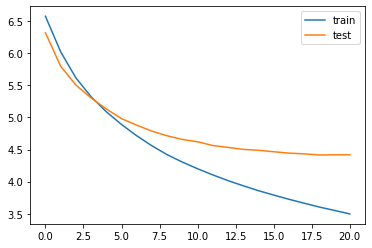

In [93]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 3-3 인퍼런스 모델 구현하기

In [95]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [97]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [99]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [100]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 3-4) 모델 테스트하기

In [102]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [103]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : apple fixed ios vulnerability year old exploited october last year trick iphones us emergency service number teenager shared link twitter tapping non stop till iphone shut however tapping link android devices redirected users site said 
실제 요약 : fixes ios that made iphones dial non stop 
예측 요약 :  apple admits iphone iphone report


원문 : inflation based wholesale price index eased december previous month due lower food inflation per government data inflation food articles slowed fuel inflation rose december however retail inflation december accelerated month high 
실제 요약 : wholesale inflation eases to in december 
예측 요약 :  inflation falls to month low of


원문 : world largest cryptocurrency bitcoin plunged much last week record around however bitcoin cash rival split original bitcoin august offering increased transaction speeds jumped nearly since friday comes developers called upgrade proposal would caused another split bitcoin 
실제 요약 : bitcoin plunges from record high of 
예측 요약 :  b

예측 요약 :  instagram tests feature to feature in


원문 : kkr took facebook share video year old batsman shubman gill belongs punjab learning bengali gill heard speaking several bengali lines like amar naam shubman kota among others gill player world cup bought kkr crore 
실제 요약 : kkr punjabi batsman shubman gill learns bengali language 
예측 요약 :  abhishek bachchan shares picture with rahane


원문 : schools colleges ghaziabad uttar pradesh remain closed tomorrow preventive measure view ongoing farmers agitation tuesday protesters broke blocked nh delhi border following delhi police used water cannons tear gas disperse farmers protesting demands including farm loan waiver farmer friendly crop insurance 
실제 요약 : schools to remain shut tomorrow over farmers protest 
예측 요약 :  maharashtra govt approves darjeeling schools


원문 : amazon said may share users payment data indian government regulators according commerce platform privacy policy keeping regulatory requirements license granted rbi amazon 

예측 요약 :  shooting injured in shooting at us


원문 : legacy years brings india range ultra hd smart full hd hd ready led tvs japanese tv giant offering minimum range led tvs icici avail extra discount sale amazon ends may apply 
실제 요약 : minimum of off on led tvs on amazon 
예측 요약 :  cabinet approves new minister


원문 : world number petra kvitova become first female tennis player win madrid open thrice defeating world number kiki saturday kvitova forced action five months stabbed burglar home december year old four titles year 
실제 요약 : stabbed by burglar wins rd madrid open title 
예측 요약 :  tennis player wins world first female


원문 : members bajrang dal rampur announced cash reward lakh beheading samajwadi party leader azam khan comes khan accused indian army saying women took away private parts soldiers bajrang dal also announced reward crore anyone paints face black feeds pork 
실제 요약 : dal declares lakh reward for beheading azam khan 
예측 요약 :  salman khan starrer tubelight attend tubelig

## Step 4 실제 결과와 요약문 비교하기

요약은 형편없다. 헤드라인은 단순 요약과는 달리 편집자의 주관에 따라 편향이나 과장이 포함된다는 점을 감안해서
유사성이 떨어질꺼란 예상은 했는데 본문에 대한 적절한 요약도 하지 못하는 점을 알 수 있었다.
비트코인이 사상 최하로 급락한 기사같은 경우  bitcoin bitcoin bitcoin surges to record 이라는 대충 보기에도 문법이 적절치 않은 요약도 있고
방콕에 있는 인도 최고 레스토랑이 문을 닫았다는 기사에 인도 최고의 도시 indian city 라는 말을 하거나
북한이 군사 능력을 증강해야한다고 했다는 기사에서는 us kim jong un (우리는 김정은) ~~뭐야 이거 무서워~~ 같은 요약을 하기도 했다.

어쨌든 영어사용자가 아니라 뉘앙스나 표현, (생략된)문법 등이 익숙하지 않은 점도 분석을 어렵게 하는 요인이긴 하지만,
적절한 요약을 성공한 사례가 드물고 아주 평이한 내용에서나 가끔 요약문과 유사한 내용을 내곤 했다.
이전 자연어 처리에서 너무 단순한 단어만 반복해서 말하는 앵무새가 된 것을 보고
단어사전이 좀 크면 좀 다채로운 표현을 사용하지 않을까 기대했는데 그렇지는 않은 거 같다.


어쨌든 단어와 단어사이의 연관성을 가지고 요약을 한다는 측면에서
이전의 영화 리뷰라던가 가사, 줄거리 등을 요약하는 것과는 달리
뉴스 기사에는 인간의 다양한 삶의 측면이 모두 반영되므로, 빈도수가 낮은 단어들을 삭제하는 것이 적절한가 하는 고민이 들었다.
예를 들면 '인플레이션' 이라는 단어가 자주 사용되진 않지만, 인플레이션 증가 / 인플레이션 감소 이 두단어만으로 
아니 인플레이션 딱 한단어만 사용해도 뉴스 내용을 어느정도는 요약가능한데 이런 단어들을 사전에서 삭제해서
오히려 중요한 단어는 빼고 변죽을 울리는 다른 내용들만 요약한게 아닐까 그런 생각이 든다.

## Step 5. Summa을 이용해서 추출적 요약해보기

In [6]:
import requests
from summa.summarizer import summarize

In [109]:
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [4]:
new_text= data.text

In [111]:
new_text.head()

0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object

In [112]:
new_text[0]

'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

In [126]:
type(new_text[0])

str

In [127]:
print(summarize(new_text[0], words=10))

In [128]:
a = new_text[0]

In [131]:
print(summarize(a, words=5))
# 왜 안되지??

In [136]:
print(summarize(new_text[1], words=10))

In [137]:
print(summarize(new_text[2], words=10))

In [138]:
print(summarize(new_text[3], words=10))

In [135]:
!pip list | grep summa

summa                         1.2.0


In [142]:
a = """ Korea introduces new COVID-19 control scheme focused on self-monitoring

By Nam Hyun-woo

President Moon Jae-in urged Koreans to refrain from "excessive fear" over the rapid spread of the Omicron variant and unveiled a new control scheme focused on self-monitoring and self-treatment by infected individuals to free up medical workers to treat severely ill patients.

"After the Omicron variant became the dominant strain in Korea, the number of daily confirmed cases has been setting new highs every day, and it is a grim reality as we are uncertain about how high the number will go and when it will peak," Moon said while presiding over a Central Disaster and Safety Countermeasure meeting on Monday.

"We need to be alert, but we don't need to have excessive fear," he said. "Even though the number of confirmed cases increases, if we control severely ill patients, the fatality rate and medical response capability, we can successfully overcome this critical moment."

Moon's remarks came as the number of daily confirmed cases reached nearly 40,000 amid the rapid spread of the Omicron variant.

Korea reported 35,286 new COVID-19 cases on Sunday, pushing up the total caseload to 1.04 million. The COVID-19 situation has been spinning out of control, with the number of daily infected cases reaching a record high of 38,691 on Saturday, up from 18,341 on Monday and 27,443 on Thursday. The rate of positive COVID-19 test results increased from 9.4 percent on Monday to 26 percent on Sunday.

Korea Disease Control and Prevention Agency Commissioner Jeong Eun-kyeong said Monday this trajectory is expected to continue for the time being and the daily tally may rise further to somewhere between 130,000 and 170,000 at the end of this month."""


In [143]:
print(summarize(a, words=5))

In [144]:
b = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [146]:
print('Summary:')
print(summarize(text, words=200))

Summary:
Trinity takes Neo to Morpheus.
Just before Neo passes out Morpheus says to him, "Welcome to the real world."
He asks Trinity why, if Morpheus thinks Neo is the One, he hasn't taken him to see the Oracle yet.
"What are you trying to tell me," asks Neo, "That I can dodge bullets?" "When you're ready," Morpheus says, "You won't have to." Just then Morpheus gets a phone call.
Cypher asks Neo if Morpheus has told him why he's here.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Morpheus, who is above Neo in the walls, breaks through the wall and lands on the agent, yelling to Trinity to get Neo out of the building.
Neo says he only knows that he can bring Morpheus out.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
Neo tries to tell him that the Oracle told him the opposite but Morpheus says, "She told you exactly what you needed to hear." They call Tank, who tells them of an exit in a 

In [147]:
c = '''
As the blockchain technology attracts attention, interest in cryptocurrency that is received as a reward is also increasing. Currently, investments and transactions are continuing with the expectation and increasing value of cryptocurrency. Accordingly, prediction for cryptocurrency price has been attempted through artificial intelligence technology and social sentiment analysis. The purpose of this paper is to develop a deep learning ensemble model for predicting the price fluctuations and one-day lag price of cryptocurrency based on the design science research method. This paper intends to perform predictive modeling on Ethereum among cryptocurrencies to make predictions more efficiently and accurately than existing models. Therefore, it collects data for five years related to Ethereum price and performs pre-processing through customized functions. In the model development stage, four LSTM models, which are efficient for time series data processing, are utilized to build an ensemble model with the optimal combination of hyperparameters found in the experimental process. Then, based on the performance evaluation scale, the superiority of the model is evaluated through comparison with other deep learning models. The results of this paper have a practical contribution that can be used as a model that shows high performance and predictive rate for cryptocurrency price prediction and price fluctuations. Besides, it shows academic contribution in that it improves the quality of research by following scientific design research procedures that solve scientific problems and create and evaluate new and innovative products in the field of information systems
'''

In [148]:
print(summarize(c, words=10))

In [149]:
len(b)

35932

In [150]:
len(c)

1679

In [151]:
len(a)

1748

아무래도 요약은 최고 10000자 이상이어야 정상적으로 작동하는가 싶다. 

In [152]:
d = '''
Convolutional Neural Networks (CNNs / ConvNets)
Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have a loss function (e.g. SVM/Softmax) on the last (fully-connected) layer and all the tips/tricks we developed for learning regular Neural Networks still apply.

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.


Architecture Overview
Recall: Regular Neural Nets. As we saw in the previous chapter, Neural Networks receive an input (a single vector), and transform it through a series of hidden layers. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. The last fully-connected layer is called the “output layer” and in classification settings it represents the class scores.

Regular Neural Nets don’t scale well to full images. In CIFAR-10, images are only of size 32x32x3 (32 wide, 32 high, 3 color channels), so a single fully-connected neuron in a first hidden layer of a regular Neural Network would have 32*32*3 = 3072 weights. This amount still seems manageable, but clearly this fully-connected structure does not scale to larger images. For example, an image of more respectable size, e.g. 200x200x3, would lead to neurons that have 200*200*3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons, so the parameters would add up quickly! Clearly, this full connectivity is wasteful and the huge number of parameters would quickly lead to overfitting.

3D volumes of neurons. Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth. (Note that the word depth here refers to the third dimension of an activation volume, not to the depth of a full Neural Network, which can refer to the total number of layers in a network.) For example, the input images in CIFAR-10 are an input volume of activations, and the volume has dimensions 32x32x3 (width, height, depth respectively). As we will soon see, the neurons in a layer will only be connected to a small region of the layer before it, instead of all of the neurons in a fully-connected manner. Moreover, the final output layer would for CIFAR-10 have dimensions 1x1x10, because by the end of the ConvNet architecture we will reduce the full image into a single vector of class scores, arranged along the depth dimension. Here is a visualization:

 
Left: A regular 3-layer Neural Network. Right: A ConvNet arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers. Every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (Red, Green, Blue channels).
A ConvNet is made up of Layers. Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters.


Layers used to build ConvNets
As we described above, a simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

Example Architecture: Overview. We will go into more details below, but a simple ConvNet for CIFAR-10 classification could have the architecture [INPUT - CONV - RELU - POOL - FC]. In more detail:

INPUT [32x32x3] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.
CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.
RELU layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.
In this way, ConvNets transform the original image layer by layer from the original pixel values to the final class scores. Note that some layers contain parameters and other don’t. In particular, the CONV/FC layers perform transformations that are a function of not only the activations in the input volume, but also of the parameters (the weights and biases of the neurons). On the other hand, the RELU/POOL layers will implement a fixed function. The parameters in the CONV/FC layers will be trained with gradient descent so that the class scores that the ConvNet computes are consistent with the labels in the training set for each image.

In summary:

A ConvNet architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)
There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)
Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function
Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)
Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)

The activations of an example ConvNet architecture. The initial volume stores the raw image pixels (left) and the last volume stores the class scores (right). Each volume of activations along the processing path is shown as a column. Since it's difficult to visualize 3D volumes, we lay out each volume's slices in rows. The last layer volume holds the scores for each class, but here we only visualize the sorted top 5 scores, and print the labels of each one. The full web-based demo is shown in the header of our website. The architecture shown here is a tiny VGG Net, which we will discuss later.
We now describe the individual layers and the details of their hyperparameters and their connectivities.


Convolutional Layer
The Conv layer is the core building block of a Convolutional Network that does most of the computational heavy lifting.

Overview and intuition without brain stuff. Let’s first discuss what the CONV layer computes without brain/neuron analogies. The CONV layer’s parameters consist of a set of learnable filters. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. For example, a typical filter on a first layer of a ConvNet might have size 5x5x3 (i.e. 5 pixels width and height, and 3 because images have depth 3, the color channels). During the forward pass, we slide (more precisely, convolve) each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Intuitively, the network will learn filters that activate when they see some type of visual feature such as an edge of some orientation or a blotch of some color on the first layer, or eventually entire honeycomb or wheel-like patterns on higher layers of the network. Now, we will have an entire set of filters in each CONV layer (e.g. 12 filters), and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension and produce the output volume.

The brain view. If you’re a fan of the brain/neuron analogies, every entry in the 3D output volume can also be interpreted as an output of a neuron that looks at only a small region in the input and shares parameters with all neurons to the left and right spatially (since these numbers all result from applying the same filter).

We now discuss the details of the neuron connectivities, their arrangement in space, and their parameter sharing scheme.

Local Connectivity. When dealing with high-dimensional inputs such as images, as we saw above it is impractical to connect neurons to all neurons in the previous volume. Instead, we will connect each neuron to only a local region of the input volume. The spatial extent of this connectivity is a hyperparameter called the receptive field of the neuron (equivalently this is the filter size). The extent of the connectivity along the depth axis is always equal to the depth of the input volume. It is important to emphasize again this asymmetry in how we treat the spatial dimensions (width and height) and the depth dimension: The connections are local in 2D space (along width and height), but always full along the entire depth of the input volume.

Example 1. For example, suppose that the input volume has size [32x32x3], (e.g. an RGB CIFAR-10 image). If the receptive field (or the filter size) is 5x5, then each neuron in the Conv Layer will have weights to a [5x5x3] region in the input volume, for a total of 5*5*3 = 75 weights (and +1 bias parameter). Notice that the extent of the connectivity along the depth axis must be 3, since this is the depth of the input volume.

Example 2. Suppose an input volume had size [16x16x20]. Then using an example receptive field size of 3x3, every neuron in the Conv Layer would now have a total of 3*3*20 = 180 connections to the input volume. Notice that, again, the connectivity is local in 2D space (e.g. 3x3), but full along the input depth (20).

 
Left: An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input: the lines that connect this column of 5 neurons do not represent the weights (i.e. these 5 neurons do not share the same weights, but they are associated with 5 different filters), they just indicate that these neurons are connected to or looking at the same receptive field or region of the input volume, i.e. they share the same receptive field but not the same weights. Right: The neurons from the Neural Network chapter remain unchanged: They still compute a dot product of their weights with the input followed by a non-linearity, but their connectivity is now restricted to be local spatially.
Spatial arrangement. We have explained the connectivity of each neuron in the Conv Layer to the input volume, but we haven’t yet discussed how many neurons there are in the output volume or how they are arranged. Three hyperparameters control the size of the output volume: the depth, stride and zero-padding. We discuss these next:

First, the depth of the output volume is a hyperparameter: it corresponds to the number of filters we would like to use, each learning to look for something different in the input. For example, if the first Convolutional Layer takes as input the raw image, then different neurons along the depth dimension may activate in presence of various oriented edges, or blobs of color. We will refer to a set of neurons that are all looking at the same region of the input as a depth column (some people also prefer the term fibre).
Second, we must specify the stride with which we slide the filter. When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 (or uncommonly 3 or more, though this is rare in practice) then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.
As we will soon see, sometimes it will be convenient to pad the input volume with zeros around the border. The size of this zero-padding is a hyperparameter. The nice feature of zero padding is that it will allow us to control the spatial size of the output volumes (most commonly as we’ll see soon we will use it to exactly preserve the spatial size of the input volume so the input and output width and height are the same).
We can compute the spatial size of the output volume as a function of the input volume size (W), the receptive field size of the Conv Layer neurons (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. You can convince yourself that the correct formula for calculating how many neurons “fit” is given by (W−F+2P)/S+1. For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output. Lets also see one more graphical example:


Illustration of spatial arrangement. In this example there is only one spatial dimension (x-axis), one neuron with a receptive field size of F = 3, the input size is W = 5, and there is zero padding of P = 1. Left: The neuron strided across the input in stride of S = 1, giving output of size (5 - 3 + 2)/1+1 = 5. Right: The neuron uses stride of S = 2, giving output of size (5 - 3 + 2)/2+1 = 3. Notice that stride S = 3 could not be used since it wouldn't fit neatly across the volume. In terms of the equation, this can be determined since (5 - 3 + 2) = 4 is not divisible by 3.
The neuron weights are in this example [1,0,-1] (shown on very right), and its bias is zero. These weights are shared across all yellow neurons (see parameter sharing below).
Use of zero-padding. In the example above on left, note that the input dimension was 5 and the output dimension was equal: also 5. This worked out so because our receptive fields were 3 and we used zero padding of 1. If there was no zero-padding used, then the output volume would have had spatial dimension of only 3, because that is how many neurons would have “fit” across the original input. In general, setting zero padding to be P=(F−1)/2 when the stride is S=1 ensures that the input volume and output volume will have the same size spatially. It is very common to use zero-padding in this way and we will discuss the full reasons when we talk more about ConvNet architectures.

Constraints on strides. Note again that the spatial arrangement hyperparameters have mutual constraints. For example, when the input has size W=10, no zero-padding is used P=0, and the filter size is F=3, then it would be impossible to use stride S=2, since (W−F+2P)/S+1=(10−3+0)/2+1=4.5, i.e. not an integer, indicating that the neurons don’t “fit” neatly and symmetrically across the input. Therefore, this setting of the hyperparameters is considered to be invalid, and a ConvNet library could throw an exception or zero pad the rest to make it fit, or crop the input to make it fit, or something. As we will see in the ConvNet architectures section, sizing the ConvNets appropriately so that all the dimensions “work out” can be a real headache, which the use of zero-padding and some design guidelines will significantly alleviate.

Real-world example. The Krizhevsky et al. architecture that won the ImageNet challenge in 2012 accepted images of size [227x227x3]. On the first Convolutional Layer, it used neurons with receptive field size F=11, stride S=4 and no zero padding P=0. Since (227 - 11)/4 + 1 = 55, and since the Conv layer had a depth of K=96, the Conv layer output volume had size [55x55x96]. Each of the 55*55*96 neurons in this volume was connected to a region of size [11x11x3] in the input volume. Moreover, all 96 neurons in each depth column are connected to the same [11x11x3] region of the input, but of course with different weights. As a fun aside, if you read the actual paper it claims that the input images were 224x224, which is surely incorrect because (224 - 11)/4 + 1 is quite clearly not an integer. This has confused many people in the history of ConvNets and little is known about what happened. My own best guess is that Alex used zero-padding of 3 extra pixels that he does not mention in the paper.

Parameter Sharing. Parameter sharing scheme is used in Convolutional Layers to control the number of parameters. Using the real-world example above, we see that there are 55*55*96 = 290,400 neurons in the first Conv Layer, and each has 11*11*3 = 363 weights and 1 bias. Together, this adds up to 290400 * 364 = 105,705,600 parameters on the first layer of the ConvNet alone. Clearly, this number is very high.

It turns out that we can dramatically reduce the number of parameters by making one reasonable assumption: That if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2). In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [55x55x96] has 96 depth slices, each of size [55x55]), we are going to constrain the neurons in each depth slice to use the same weights and bias. With this parameter sharing scheme, the first Conv Layer in our example would now have only 96 unique set of weights (one for each depth slice), for a total of 96*11*11*3 = 34,848 unique weights, or 34,944 parameters (+96 biases). Alternatively, all 55*55 neurons in each depth slice will now be using the same parameters. In practice during backpropagation, every neuron in the volume will compute the gradient for its weights, but these gradients will be added up across each depth slice and only update a single set of weights per slice.

Notice that if all neurons in a single depth slice are using the same weight vector, then the forward pass of the CONV layer can in each depth slice be computed as a convolution of the neuron’s weights with the input volume (Hence the name: Convolutional Layer). This is why it is common to refer to the sets of weights as a filter (or a kernel), that is convolved with the input.


Example filters learned by Krizhevsky et al. Each of the 96 filters shown here is of size [11x11x3], and each one is shared by the 55*55 neurons in one depth slice. Notice that the parameter sharing assumption is relatively reasonable: If detecting a horizontal edge is important at some location in the image, it should intuitively be useful at some other location as well due to the translationally-invariant structure of images. There is therefore no need to relearn to detect a horizontal edge at every one of the 55*55 distinct locations in the Conv layer output volume.
Note that sometimes the parameter sharing assumption may not make sense. This is especially the case when the input images to a ConvNet have some specific centered structure, where we should expect, for example, that completely different features should be learned on one side of the image than another. One practical example is when the input are faces that have been centered in the image. You might expect that different eye-specific or hair-specific features could (and should) be learned in different spatial locations. In that case it is common to relax the parameter sharing scheme, and instead simply call the layer a Locally-Connected Layer.

Numpy examples. To make the discussion above more concrete, lets express the same ideas but in code and with a specific example. Suppose that the input volume is a numpy array X. Then:

A depth column (or a fibre) at position (x,y) would be the activations X[x,y,:].
A depth slice, or equivalently an activation map at depth d would be the activations X[:,:,d].
Conv Layer Example. Suppose that the input volume X has shape X.shape: (11,11,4). Suppose further that we use no zero padding (P=0), that the filter size is F=5, and that the stride is S=2. The output volume would therefore have spatial size (11-5)/2+1 = 4, giving a volume with width and height of 4. The activation map in the output volume (call it V), would then look as follows (only some of the elements are computed in this example):

V[0,0,0] = np.sum(X[:5,:5,:] * W0) + b0
V[1,0,0] = np.sum(X[2:7,:5,:] * W0) + b0
V[2,0,0] = np.sum(X[4:9,:5,:] * W0) + b0
V[3,0,0] = np.sum(X[6:11,:5,:] * W0) + b0
Remember that in numpy, the operation * above denotes elementwise multiplication between the arrays. Notice also that the weight vector W0 is the weight vector of that neuron and b0 is the bias. Here, W0 is assumed to be of shape W0.shape: (5,5,4), since the filter size is 5 and the depth of the input volume is 4. Notice that at each point, we are computing the dot product as seen before in ordinary neural networks. Also, we see that we are using the same weight and bias (due to parameter sharing), and where the dimensions along the width are increasing in steps of 2 (i.e. the stride). To construct a second activation map in the output volume, we would have:

V[0,0,1] = np.sum(X[:5,:5,:] * W1) + b1
V[1,0,1] = np.sum(X[2:7,:5,:] * W1) + b1
V[2,0,1] = np.sum(X[4:9,:5,:] * W1) + b1
V[3,0,1] = np.sum(X[6:11,:5,:] * W1) + b1
V[0,1,1] = np.sum(X[:5,2:7,:] * W1) + b1 (example of going along y)
V[2,3,1] = np.sum(X[4:9,6:11,:] * W1) + b1 (or along both)
where we see that we are indexing into the second depth dimension in V (at index 1) because we are computing the second activation map, and that a different set of parameters (W1) is now used. In the example above, we are for brevity leaving out some of the other operations the Conv Layer would perform to fill the other parts of the output array V. Additionally, recall that these activation maps are often followed elementwise through an activation function such as ReLU, but this is not shown here.

Summary. To summarize, the Conv Layer:

Accepts a volume of size W1×H1×D1
Requires four hyperparameters:
Number of filters K,
their spatial extent F,
the stride S,
the amount of zero padding P.
Produces a volume of size W2×H2×D2 where:
W2=(W1−F+2P)/S+1
H2=(H1−F+2P)/S+1 (i.e. width and height are computed equally by symmetry)
D2=K
With parameter sharing, it introduces F⋅F⋅D1 weights per filter, for a total of (F⋅F⋅D1)⋅K weights and K biases.
In the output volume, the d-th depth slice (of size W2×H2) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of S, and then offset by d-th bias.
A common setting of the hyperparameters is F=3,S=1,P=1. However, there are common conventions and rules of thumb that motivate these hyperparameters. See the ConvNet architectures section below.

Convolution Demo. Below is a running demo of a CONV layer. Since 3D volumes are hard to visualize, all the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows. The input volume is of size W1=5,H1=5,D1=3, and the CONV layer parameters are K=2,F=3,S=2,P=1. That is, we have two filters of size 3×3, and they are applied with a stride of 2. Therefore, the output volume size has spatial size (5 - 3 + 2)/2 + 1 = 3. Moreover, notice that a padding of P=1 is applied to the input volume, making the outer border of the input volume zero. The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias.


Implementation as Matrix Multiplication. Note that the convolution operation essentially performs dot products between the filters and local regions of the input. A common implementation pattern of the CONV layer is to take advantage of this fact and formulate the forward pass of a convolutional layer as one big matrix multiply as follows:

The local regions in the input image are stretched out into columns in an operation commonly called im2col. For example, if the input is [227x227x3] and it is to be convolved with 11x11x3 filters at stride 4, then we would take [11x11x3] blocks of pixels in the input and stretch each block into a column vector of size 11*11*3 = 363. Iterating this process in the input at stride of 4 gives (227-11)/4+1 = 55 locations along both width and height, leading to an output matrix X_col of im2col of size [363 x 3025], where every column is a stretched out receptive field and there are 55*55 = 3025 of them in total. Note that since the receptive fields overlap, every number in the input volume may be duplicated in multiple distinct columns.
The weights of the CONV layer are similarly stretched out into rows. For example, if there are 96 filters of size [11x11x3] this would give a matrix W_row of size [96 x 363].
The result of a convolution is now equivalent to performing one large matrix multiply np.dot(W_row, X_col), which evaluates the dot product between every filter and every receptive field location. In our example, the output of this operation would be [96 x 3025], giving the output of the dot product of each filter at each location.
The result must finally be reshaped back to its proper output dimension [55x55x96].
This approach has the downside that it can use a lot of memory, since some values in the input volume are replicated multiple times in X_col. However, the benefit is that there are many very efficient implementations of Matrix Multiplication that we can take advantage of (for example, in the commonly used BLAS API). Moreover, the same im2col idea can be reused to perform the pooling operation, which we discuss next.

Backpropagation. The backward pass for a convolution operation (for both the data and the weights) is also a convolution (but with spatially-flipped filters). This is easy to derive in the 1-dimensional case with a toy example (not expanded on for now).

1x1 convolution. As an aside, several papers use 1x1 convolutions, as first investigated by Network in Network. Some people are at first confused to see 1x1 convolutions especially when they come from signal processing background. Normally signals are 2-dimensional so 1x1 convolutions do not make sense (it’s just pointwise scaling). However, in ConvNets this is not the case because one must remember that we operate over 3-dimensional volumes, and that the filters always extend through the full depth of the input volume. For example, if the input is [32x32x3] then doing 1x1 convolutions would effectively be doing 3-dimensional dot products (since the input depth is 3 channels).

Dilated convolutions. A recent development (e.g. see paper by Fisher Yu and Vladlen Koltun) is to introduce one more hyperparameter to the CONV layer called the dilation. So far we’ve only discussed CONV filters that are contiguous. However, it’s possible to have filters that have spaces between each cell, called dilation. As an example, in one dimension a filter w of size 3 would compute over input x the following: w[0]*x[0] + w[1]*x[1] + w[2]*x[2]. This is dilation of 0. For dilation 1 the filter would instead compute w[0]*x[0] + w[1]*x[2] + w[2]*x[4]; In other words there is a gap of 1 between the applications. This can be very useful in some settings to use in conjunction with 0-dilated filters because it allows you to merge spatial information across the inputs much more agressively with fewer layers. For example, if you stack two 3x3 CONV layers on top of each other then you can convince yourself that the neurons on the 2nd layer are a function of a 5x5 patch of the input (we would say that the effective receptive field of these neurons is 5x5). If we use dilated convolutions then this effective receptive field would grow much quicker.


Pooling Layer
It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations. Every MAX operation would in this case be taking a max over 4 numbers (little 2x2 region in some depth slice). The depth dimension remains unchanged. More generally, the pooling layer:

Accepts a volume of size W1×H1×D1
Requires two hyperparameters:
their spatial extent F,
the stride S,
Produces a volume of size W2×H2×D2 where:
W2=(W1−F)/S+1
H2=(H1−F)/S+1
D2=D1
Introduces zero parameters since it computes a fixed function of the input
For Pooling layers, it is not common to pad the input using zero-padding.
It is worth noting that there are only two commonly seen variations of the max pooling layer found in practice: A pooling layer with F=3,S=2 (also called overlapping pooling), and more commonly F=2,S=2. Pooling sizes with larger receptive fields are too destructive.

General pooling. In addition to max pooling, the pooling units can also perform other functions, such as average pooling or even L2-norm pooling. Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.

 
Pooling layer downsamples the volume spatially, independently in each depth slice of the input volume. Left: In this example, the input volume of size [224x224x64] is pooled with filter size 2, stride 2 into output volume of size [112x112x64]. Notice that the volume depth is preserved. Right: The most common downsampling operation is max, giving rise to max pooling, here shown with a stride of 2. That is, each max is taken over 4 numbers (little 2x2 square).
Backpropagation. Recall from the backpropagation chapter that the backward pass for a max(x, y) operation has a simple interpretation as only routing the gradient to the input that had the highest value in the forward pass. Hence, during the forward pass of a pooling layer it is common to keep track of the index of the max activation (sometimes also called the switches) so that gradient routing is efficient during backpropagation.

Getting rid of pooling. Many people dislike the pooling operation and think that we can get away without it. For example, Striving for Simplicity: The All Convolutional Net proposes to discard the pooling layer in favor of architecture that only consists of repeated CONV layers. To reduce the size of the representation they suggest using larger stride in CONV layer once in a while. Discarding pooling layers has also been found to be important in training good generative models, such as variational autoencoders (VAEs) or generative adversarial networks (GANs). It seems likely that future architectures will feature very few to no pooling layers.


Normalization Layer
Many types of normalization layers have been proposed for use in ConvNet architectures, sometimes with the intentions of implementing inhibition schemes observed in the biological brain. However, these layers have since fallen out of favor because in practice their contribution has been shown to be minimal, if any. For various types of normalizations, see the discussion in Alex Krizhevsky’s cuda-convnet library API.


Fully-connected layer
Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Their activations can hence be computed with a matrix multiplication followed by a bias offset. See the Neural Network section of the notes for more information.


Converting FC layers to CONV layers
It is worth noting that the only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input, and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. Therefore, it turns out that it’s possible to convert between FC and CONV layers:

For any CONV layer there is an FC layer that implements the same forward function. The weight matrix would be a large matrix that is mostly zero except for at certain blocks (due to local connectivity) where the weights in many of the blocks are equal (due to parameter sharing).
Conversely, any FC layer can be converted to a CONV layer. For example, an FC layer with K=4096 that is looking at some input volume of size 7×7×512 can be equivalently expressed as a CONV layer with F=7,P=0,S=1,K=4096. In other words, we are setting the filter size to be exactly the size of the input volume, and hence the output will simply be 1×1×4096 since only a single depth column “fits” across the input volume, giving identical result as the initial FC layer.
FC->CONV conversion. Of these two conversions, the ability to convert an FC layer to a CONV layer is particularly useful in practice. Consider a ConvNet architecture that takes a 224x224x3 image, and then uses a series of CONV layers and POOL layers to reduce the image to an activations volume of size 7x7x512 (in an AlexNet architecture that we’ll see later, this is done by use of 5 pooling layers that downsample the input spatially by a factor of two each time, making the final spatial size 224/2/2/2/2/2 = 7). From there, an AlexNet uses two FC layers of size 4096 and finally the last FC layers with 1000 neurons that compute the class scores. We can convert each of these three FC layers to CONV layers as described above:

Replace the first FC layer that looks at [7x7x512] volume with a CONV layer that uses filter size F=7, giving output volume [1x1x4096].
Replace the second FC layer with a CONV layer that uses filter size F=1, giving output volume [1x1x4096]
Replace the last FC layer similarly, with F=1, giving final output [1x1x1000]
Each of these conversions could in practice involve manipulating (e.g. reshaping) the weight matrix W in each FC layer into CONV layer filters. It turns out that this conversion allows us to “slide” the original ConvNet very efficiently across many spatial positions in a larger image, in a single forward pass.

For example, if 224x224 image gives a volume of size [7x7x512] - i.e. a reduction by 32, then forwarding an image of size 384x384 through the converted architecture would give the equivalent volume in size [12x12x512], since 384/32 = 12. Following through with the next 3 CONV layers that we just converted from FC layers would now give the final volume of size [6x6x1000], since (12 - 7)/1 + 1 = 6. Note that instead of a single vector of class scores of size [1x1x1000], we’re now getting an entire 6x6 array of class scores across the 384x384 image.

Evaluating the original ConvNet (with FC layers) independently across 224x224 crops of the 384x384 image in strides of 32 pixels gives an identical result to forwarding the converted ConvNet one time.

Naturally, forwarding the converted ConvNet a single time is much more efficient than iterating the original ConvNet over all those 36 locations, since the 36 evaluations share computation. This trick is often used in practice to get better performance, where for example, it is common to resize an image to make it bigger, use a converted ConvNet to evaluate the class scores at many spatial positions and then average the class scores.

Lastly, what if we wanted to efficiently apply the original ConvNet over the image but at a stride smaller than 32 pixels? We could achieve this with multiple forward passes. For example, note that if we wanted to use a stride of 16 pixels we could do so by combining the volumes received by forwarding the converted ConvNet twice: First over the original image and second over the image but with the image shifted spatially by 16 pixels along both width and height.

An IPython Notebook on Net Surgery shows how to perform the conversion in practice, in code (using Caffe)

ConvNet Architectures
We have seen that Convolutional Networks are commonly made up of only three layer types: CONV, POOL (we assume Max pool unless stated otherwise) and FC (short for fully-connected). We will also explicitly write the RELU activation function as a layer, which applies elementwise non-linearity. In this section we discuss how these are commonly stacked together to form entire ConvNets.


Layer Patterns
The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point, it is common to transition to fully-connected layers. The last fully-connected layer holds the output, such as the class scores. In other words, the most common ConvNet architecture follows the pattern:

INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC

where the * indicates repetition, and the POOL? indicates an optional pooling layer. Moreover, N >= 0 (and usually N <= 3), M >= 0, K >= 0 (and usually K < 3). For example, here are some common ConvNet architectures you may see that follow this pattern:

INPUT -> FC, implements a linear classifier. Here N = M = K = 0.
INPUT -> CONV -> RELU -> FC
INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC. Here we see that there is a single CONV layer between every POOL layer.
INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC Here we see two CONV layers stacked before every POOL layer. This is generally a good idea for larger and deeper networks, because multiple stacked CONV layers can develop more complex features of the input volume before the destructive pooling operation.
Prefer a stack of small filter CONV to one large receptive field CONV layer. Suppose that you stack three 3x3 CONV layers on top of each other (with non-linearities in between, of course). In this arrangement, each neuron on the first CONV layer has a 3x3 view of the input volume. A neuron on the second CONV layer has a 3x3 view of the first CONV layer, and hence by extension a 5x5 view of the input volume. Similarly, a neuron on the third CONV layer has a 3x3 view of the 2nd CONV layer, and hence a 7x7 view of the input volume. Suppose that instead of these three layers of 3x3 CONV, we only wanted to use a single CONV layer with 7x7 receptive fields. These neurons would have a receptive field size of the input volume that is identical in spatial extent (7x7), but with several disadvantages. First, the neurons would be computing a linear function over the input, while the three stacks of CONV layers contain non-linearities that make their features more expressive. Second, if we suppose that all the volumes have C channels, then it can be seen that the single 7x7 CONV layer would contain C×(7×7×C)=49C2 parameters, while the three 3x3 CONV layers would only contain 3×(C×(3×3×C))=27C2 parameters. Intuitively, stacking CONV layers with tiny filters as opposed to having one CONV layer with big filters allows us to express more powerful features of the input, and with fewer parameters. As a practical disadvantage, we might need more memory to hold all the intermediate CONV layer results if we plan to do backpropagation.

Recent departures. It should be noted that the conventional paradigm of a linear list of layers has recently been challenged, in Google’s Inception architectures and also in current (state of the art) Residual Networks from Microsoft Research Asia. Both of these (see details below in case studies section) feature more intricate and different connectivity structures.

In practice: use whatever works best on ImageNet. If you’re feeling a bit of a fatigue in thinking about the architectural decisions, you’ll be pleased to know that in 90% or more of applications you should not have to worry about these. I like to summarize this point as “don’t be a hero”: Instead of rolling your own architecture for a problem, you should look at whatever architecture currently works best on ImageNet, download a pretrained model and finetune it on your data. You should rarely ever have to train a ConvNet from scratch or design one from scratch. I also made this point at the Deep Learning school.


Layer Sizing Patterns
Until now we’ve omitted mentions of common hyperparameters used in each of the layers in a ConvNet. We will first state the common rules of thumb for sizing the architectures and then follow the rules with a discussion of the notation:

The input layer (that contains the image) should be divisible by 2 many times. Common numbers include 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.

The conv layers should be using small filters (e.g. 3x3 or at most 5x5), using a stride of S=1, and crucially, padding the input volume with zeros in such way that the conv layer does not alter the spatial dimensions of the input. That is, when F=3, then using P=1 will retain the original size of the input. When F=5, P=2. For a general F, it can be seen that P=(F−1)/2 preserves the input size. If you must use bigger filter sizes (such as 7x7 or so), it is only common to see this on the very first conv layer that is looking at the input image.

The pool layers are in charge of downsampling the spatial dimensions of the input. The most common setting is to use max-pooling with 2x2 receptive fields (i.e. F=2), and with a stride of 2 (i.e. S=2). Note that this discards exactly 75% of the activations in an input volume (due to downsampling by 2 in both width and height). Another slightly less common setting is to use 3x3 receptive fields with a stride of 2, but this makes “fitting” more complicated (e.g., a 32x32x3 layer would require zero padding to be used with a max-pooling layer with 3x3 receptive field and stride 2). It is very uncommon to see receptive field sizes for max pooling that are larger than 3 because the pooling is then too lossy and aggressive. This usually leads to worse performance.

Reducing sizing headaches. The scheme presented above is pleasing because all the CONV layers preserve the spatial size of their input, while the POOL layers alone are in charge of down-sampling the volumes spatially. In an alternative scheme where we use strides greater than 1 or don’t zero-pad the input in CONV layers, we would have to very carefully keep track of the input volumes throughout the CNN architecture and make sure that all strides and filters “work out”, and that the ConvNet architecture is nicely and symmetrically wired.

Why use stride of 1 in CONV? Smaller strides work better in practice. Additionally, as already mentioned stride 1 allows us to leave all spatial down-sampling to the POOL layers, with the CONV layers only transforming the input volume depth-wise.

Why use padding? In addition to the aforementioned benefit of keeping the spatial sizes constant after CONV, doing this actually improves performance. If the CONV layers were to not zero-pad the inputs and only perform valid convolutions, then the size of the volumes would reduce by a small amount after each CONV, and the information at the borders would be “washed away” too quickly.

Compromising based on memory constraints. In some cases (especially early in the ConvNet architectures), the amount of memory can build up very quickly with the rules of thumb presented above. For example, filtering a 224x224x3 image with three 3x3 CONV layers with 64 filters each and padding 1 would create three activation volumes of size [224x224x64]. This amounts to a total of about 10 million activations, or 72MB of memory (per image, for both activations and gradients). Since GPUs are often bottlenecked by memory, it may be necessary to compromise. In practice, people prefer to make the compromise at only the first CONV layer of the network. For example, one compromise might be to use a first CONV layer with filter sizes of 7x7 and stride of 2 (as seen in a ZF net). As another example, an AlexNet uses filter sizes of 11x11 and stride of 4.


Case studies
There are several architectures in the field of Convolutional Networks that have a name. The most common are:

LeNet. The first successful applications of Convolutional Networks were developed by Yann LeCun in 1990’s. Of these, the best known is the LeNet architecture that was used to read zip codes, digits, etc.
AlexNet. The first work that popularized Convolutional Networks in Computer Vision was the AlexNet, developed by Alex Krizhevsky, Ilya Sutskever and Geoff Hinton. The AlexNet was submitted to the ImageNet ILSVRC challenge in 2012 and significantly outperformed the second runner-up (top 5 error of 16% compared to runner-up with 26% error). The Network had a very similar architecture to LeNet, but was deeper, bigger, and featured Convolutional Layers stacked on top of each other (previously it was common to only have a single CONV layer always immediately followed by a POOL layer).
ZF Net. The ILSVRC 2013 winner was a Convolutional Network from Matthew Zeiler and Rob Fergus. It became known as the ZFNet (short for Zeiler & Fergus Net). It was an improvement on AlexNet by tweaking the architecture hyperparameters, in particular by expanding the size of the middle convolutional layers and making the stride and filter size on the first layer smaller.
GoogLeNet. The ILSVRC 2014 winner was a Convolutional Network from Szegedy et al. from Google. Its main contribution was the development of an Inception Module that dramatically reduced the number of parameters in the network (4M, compared to AlexNet with 60M). Additionally, this paper uses Average Pooling instead of Fully Connected layers at the top of the ConvNet, eliminating a large amount of parameters that do not seem to matter much. There are also several followup versions to the GoogLeNet, most recently Inception-v4.
VGGNet. The runner-up in ILSVRC 2014 was the network from Karen Simonyan and Andrew Zisserman that became known as the VGGNet. Its main contribution was in showing that the depth of the network is a critical component for good performance. Their final best network contains 16 CONV/FC layers and, appealingly, features an extremely homogeneous architecture that only performs 3x3 convolutions and 2x2 pooling from the beginning to the end. Their pretrained model is available for plug and play use in Caffe. A downside of the VGGNet is that it is more expensive to evaluate and uses a lot more memory and parameters (140M). Most of these parameters are in the first fully connected layer, and it was since found that these FC layers can be removed with no performance downgrade, significantly reducing the number of necessary parameters.
ResNet. Residual Network developed by Kaiming He et al. was the winner of ILSVRC 2015. It features special skip connections and a heavy use of batch normalization. The architecture is also missing fully connected layers at the end of the network. The reader is also referred to Kaiming’s presentation (video, slides), and some recent experiments that reproduce these networks in Torch. ResNets are currently by far state of the art Convolutional Neural Network models and are the default choice for using ConvNets in practice (as of May 10, 2016). In particular, also see more recent developments that tweak the original architecture from Kaiming He et al. Identity Mappings in Deep Residual Networks (published March 2016).
VGGNet in detail. Lets break down the VGGNet in more detail as a case study. The whole VGGNet is composed of CONV layers that perform 3x3 convolutions with stride 1 and pad 1, and of POOL layers that perform 2x2 max pooling with stride 2 (and no padding). We can write out the size of the representation at each step of the processing and keep track of both the representation size and the total number of weights:

INPUT: [224x224x3]        memory:  224*224*3=150K   weights: 0
CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*3)*64 = 1,728
CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*64)*64 = 36,864
POOL2: [112x112x64]  memory:  112*112*64=800K   weights: 0
CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*64)*128 = 73,728
CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*128)*128 = 147,456
POOL2: [56x56x128]  memory:  56*56*128=400K   weights: 0
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*128)*256 = 294,912
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
POOL2: [28x28x256]  memory:  28*28*256=200K   weights: 0
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*256)*512 = 1,179,648
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
POOL2: [14x14x512]  memory:  14*14*512=100K   weights: 0
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
POOL2: [7x7x512]  memory:  7*7*512=25K  weights: 0
FC: [1x1x4096]  memory:  4096  weights: 7*7*512*4096 = 102,760,448
FC: [1x1x4096]  memory:  4096  weights: 4096*4096 = 16,777,216
FC: [1x1x1000]  memory:  1000 weights: 4096*1000 = 4,096,000

TOTAL memory: 24M * 4 bytes ~= 93MB / image (only forward! ~*2 for bwd)
TOTAL params: 138M parameters
As is common with Convolutional Networks, notice that most of the memory (and also compute time) is used in the early CONV layers, and that most of the parameters are in the last FC layers. In this particular case, the first FC layer contains 100M weights, out of a total of 140M.


Computational Considerations
The largest bottleneck to be aware of when constructing ConvNet architectures is the memory bottleneck. Many modern GPUs have a limit of 3/4/6GB memory, with the best GPUs having about 12GB of memory. There are three major sources of memory to keep track of:

From the intermediate volume sizes: These are the raw number of activations at every layer of the ConvNet, and also their gradients (of equal size). Usually, most of the activations are on the earlier layers of a ConvNet (i.e. first Conv Layers). These are kept around because they are needed for backpropagation, but a clever implementation that runs a ConvNet only at test time could in principle reduce this by a huge amount, by only storing the current activations at any layer and discarding the previous activations on layers below.
From the parameter sizes: These are the numbers that hold the network parameters, their gradients during backpropagation, and commonly also a step cache if the optimization is using momentum, Adagrad, or RMSProp. Therefore, the memory to store the parameter vector alone must usually be multiplied by a factor of at least 3 or so.
Every ConvNet implementation has to maintain miscellaneous memory, such as the image data batches, perhaps their augmented versions, etc.
Once you have a rough estimate of the total number of values (for activations, gradients, and misc), the number should be converted to size in GB. Take the number of values, multiply by 4 to get the raw number of bytes (since every floating point is 4 bytes, or maybe by 8 for double precision), and then divide by 1024 multiple times to get the amount of memory in KB, MB, and finally GB. If your network doesn’t fit, a common heuristic to “make it fit” is to decrease the batch size, since most of the memory is usually consumed by the activations.
'''

In [153]:
len(d)

52962

In [154]:
print(summarize(d, words=50))

If the receptive field (or the filter size) is 5x5, then each neuron in the Conv Layer will have weights to a [5x5x3] region in the input volume, for a total of 5*5*3 = 75 weights (and +1 bias parameter).


### 의외로 긴 문장에선 성공적으로 요약을 한거 같다.

In [7]:
for i in range(30):
    print('원문 :',new_text[i])
    print('추출 요약 :',summarize(new_text[i], words=10))
    print('헤드라인 :',data.headlines[i])

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.
헤드라인 : upGrad learner switches to career in ML & Al with 90% salary hike
원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
추출 요약 : 
헤드라인 : Delhi techie wins free food from Swiggy for one year on CRED
원문 : New Zealand defeated India by 8 wickets in 

혹시 몰라서 여러 개의 추출요약을 한 번에 하니까 같은 인덱스도 정상적으로 추출이 가능한 경우가 있었다.
이유는 잘 모르겠지만 전처리 과정에서 원본에 뭔가 수정이 가해져서이거나(데이터만 따로 다시 읽어와서 진행함),
추출요약이 잘되도록 하는 전처리 과정이 있는데 그것이 생략되었거나 등의 이유가 있을꺼 같다.
또한 추출이 정상적으로 일어나는 인덱스와 잘 안나오는 인덱스의 차이를 대조해봐도 특별한 이유를 찾을 수 없었다.


추출이 정상적으로 일어나는 경우도 뭔가 맥락을 파악해서 주요 언어만 추출하기보다도
원문의 맨 마지막만 앵무새처럼 반복하기만 했는데, 여러 길이의 원문을 넣어서 실험해본 결과로 추측컨대
summarize 모듈은 짧은 문맥(뉴스 기사와 같은) 보다는 좀더 긴 내용을 요약하는 용도로 만들어 진거 같다.
어느정도 반복되는 단어나 유사한 문맥을 통해 단어나 문장들을 추출하는 형식을 가질 것으로 예상된다.


슬프게도 보통 문단의 마지막에 핵심을 다시 환기하여 요약하는 뉴스의 특성상
내용적인 측면뿐만 아니라 문법적인 측면에서도 추상적 요약보다 추출적 요약이 더 나은 결과를 보였다.
이러면 뉴스를 뒤부터 10단어 슬라이싱 한 것이 추상적 요약, 추출적 요약보다 더 정확하다는 결론이 나온다.


뉴스라는 글은 목적성이나 여러 측면에서 일반적인 글과는 다른점이 많으므로, 뉴스 요약에는 기존의 사용하는 모델이아닌
뉴스라는 특이점을 잘 살릴 수 있는 학습모델이 필요해 보인다. 
위에서 말한 전처리 과정도 다르게 해야하는 점도 있고, 헤드라인과 일반 요약이 조금 다르기 때문에 적절한 타겟으로
학습이 되었는가도 의문이다.